# Eksperimen 1: Clean Image OCR
Gunakan notebook ini untuk eksplorasi awal ekstraksi teks dari gambar bersih.

In [ ]:
# Tulis kode eksperimen di sini
print('Setup OCR experiment...')

Bagian 1: Persiapan Environment
Langkah pertama adalah menginstal pustaka yang diperlukan untuk pengolahan citra dan OCR.

In [1]:
# Jalankan di cell pertama
!pip install easyocr opencv-python matplotlib transformers pillow torch

  Using cached ninja-1.13.0-py3-none-macosx_10_9_universal2.whl.metadata (5.1 kB)
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 2.1 MB/s  0:00:05 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 4.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 5.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.2 MB/s  0:00:01 eta 0:00:010m
Using cached ninja-1.13.0-py3-none-macosx_10_9_universal2.whl (310 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 2.4 MB/s  0:00:04m0:00:0100:01
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [easyocr]2/14 [transformers]ub]


Bagian 2: Preprocessing Citra
Karena dataset Anda berupa tulisan di kertas, tantangan terbesarnya adalah bayangan dan noise. Kita akan menguji apakah pembersihan gambar meningkatkan akurasi

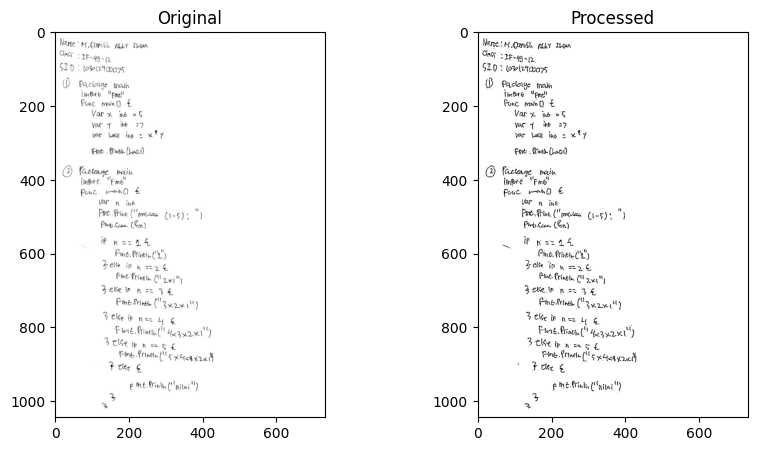

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def preprocess_for_ocr(image_path):
    # Load gambar
    img = cv2.imread(image_path)
    # Ubah ke Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Adaptive Thresholding untuk menangani pencahayaan tidak rata pada kertas
    # Ini akan membuat background menjadi putih bersih dan teks hitam pekat
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 11, 2)
    
    # Denoising untuk menghilangkan bintik-bintik kecil
    kernel = np.ones((1, 1), np.uint8)
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    return img, clean

# Test visualisasi
original, processed = preprocess_for_ocr('../../dataset/TP_MOD05_103012400075_MDANOSHABBYIHSAN.png')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(original)
plt.subplot(1,2,2); plt.title("Processed"); plt.imshow(processed, cmap='gray')
plt.show()

Bagian 3: Implementasi Baseline OCR
Kita akan membandingkan dua pendekatan: EasyOCR (ringan dan cepat) dan TrOCR (berbasis Transformer, sangat akurat untuk tulisan tangan).

A. Menggunakan EasyOCR

In [4]:
import easyocr

reader = easyocr.Reader(['id', 'en']) # Mendukung Bahasa Indonesia & Inggris

def run_easyocr(image_path):
    results = reader.readtext(image_path, detail=0)
    return "\n".join(results)

print("Hasil EasyOCR:")
print(run_easyocr('../../dataset/TP_MOD05_103012400075_MDANOSHABBYIHSAN.png'))

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteHasil EasyOCR:


/opt/anaconda3/envs/perch_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


M,Ounsk
nUsY
Ikçan
1F-49 `[2
SI D
(0321240075
Paclzagc
maih
Imfor €
'fme"
min ()
{
Var x
Ihl
var
ih6
27
vat
Lasil
int
x * /
(ne . (riktlh (hacil)
Imain
Ibnpr €
'fme"
Fenc
Vem ()
4
Var
ine
Ptrt. frinc ("mulas ((-5) :
Pn.Sccn ( Qn)
iF
h = =
1 {
Fmnt.
81"
7 elfe
ip
3=2 4
Fmt frinél (" 2x1")
3 else iF
22 3 {
fmf.frineh ("3x2x1")
3 elr vF
n ==
L(
4
Fme.friwélu ( ' Zx3x2x1')
3 clk+ CF
22
5 {
Fíne ffıneł (''5 *4<8x2xi
} Clsc
4
f mt
('nilai')
3
Name `
Cass
func
(cclagł
Prineły (
Priulk


B. Menggunakan TrOCR (Microsoft)
TrOCR adalah pilihan terbaik untuk tulisan tangan saat ini karena menggunakan Vision Transformer (ViT).

In [5]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

# Load model khusus tulisan tangan (handwritten)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

def run_trocr(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# Catatan: TrOCR bekerja paling baik jika teks dipotong per baris.

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
print(run_trocr('../../dataset/TP_MOD05_103012400075_MDANOSHABBYIHSAN.png'))

0 1


In [7]:
print(run_easyocr('../../dataset/if4908_103012530014_nomor1.jpg'))

/opt/anaconda3/envs/perch_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


prograr Eokrlp::
karaus
Tisu
[uluca
?JivhM
Covpi
oxw(
hosı
'narge
(Igf ma
[npv+ ( M)
Cibven (
icdo
Talcon
Fvlvhar
Galvca
Pz-
Fisven
{ro
~Orve
usal
(fne
Tnyen }
(Fvivaw
{n1a }
{2-4)
0,+Put (Vasıl)
Pulhaa


In [8]:
print(run_trocr('../../dataset/if4908_103012530014_nomor1.jpg'))

0 1
